In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


**Data Set read**

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
#upload dataset
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving deu.txt to deu.txt
User uploaded file "deu.txt" with length 14118330 bytes


In [0]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [7]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.",
        'Wenn jemand Fremdes dir sagt, dass du dich wie ein Muttersprachler anhörst, bedeutet das wahrscheinlich: Er hat etwas an deinem Sprechen bemerkt, dass dich als Nicht-Muttersprachler verraten hat. Mit anderen Worten: Du hörst dich nicht wirklich wie ein Muttersprachler an.'],
       ['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
        'Es ist wohl unmöglich, einen vollkommen 

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.



In [0]:
deu_eng = deu_eng[:50000,:]


# **Text Pre-Processing**

**Text Cleaning**

We will get rid of the punctuation marks, and then convert the text to lower case.



In [0]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [10]:
deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['The man died of cancer', 'Der Mann starb an Krebs'],
       ['The man lay motionless', 'Der Mann lag bewegungslos da'],
       ['The man must be insane', 'Der Mann muss geistesgestört sein']],
      dtype='<U537')

In [0]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [12]:
deu_eng


array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['the man died of cancer', 'der mann starb an krebs'],
       ['the man lay motionless', 'der mann lag bewegungslos da'],
       ['the man must be insane', 'der mann muss geistesgestört sein']],
      dtype='<U537')

**Text to Sequence Conversion**


To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [0]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [0]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

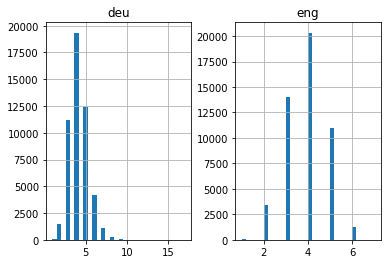

In [15]:

length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6352


In [19]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 11
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10678


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.



In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

**Model Building**

We will now split the data into train and test set for model training and evaluation, respectively.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [0]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [0]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [25]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

W0830 11:34:13.226854 140163629475712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 11:34:13.278398 140163629475712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 11:34:13.284222 140163629475712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 11:34:14.253954 140163629475712 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3239: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instruct

Please note that we have used 'sparse_categorical_crossentropy' as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using ModelCheckpoint() to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [26]:
filename = 'model.h1.30_aug_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

W0830 11:36:34.984956 140163629475712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 14s 439us/step - loss: 3.5474 - val_loss: 2.9592

Epoch 00001: val_loss improved from inf to 2.95915, saving model to model.h1.30_aug_19
Epoch 2/30
32000/32000 [==============================] - 8s 239us/step - loss: 2.8970 - val_loss: 2.8455

Epoch 00002: val_loss improved from 2.95915 to 2.84553, saving model to model.h1.30_aug_19
Epoch 3/30
32000/32000 [==============================] - 8s 240us/step - loss: 2.7277 - val_loss: 2.7317

Epoch 00003: val_loss improved from 2.84553 to 2.73173, saving model to model.h1.30_aug_19
Epoch 4/30
32000/32000 [==============================] - 8s 241us/step - loss: 2.5490 - val_loss: 2.5972

Epoch 00004: val_loss improved from 2.73173 to 2.59717, saving model to model.h1.30_aug_19
Epoch 5/30
32000/32000 [==============================] - 8s 243us/step - loss: 2.3873 - val_loss: 2.4212

Epoch 00005: val_loss improved from 2.59717 to 2.42115,

Let's compare the training loss and the validation loss.

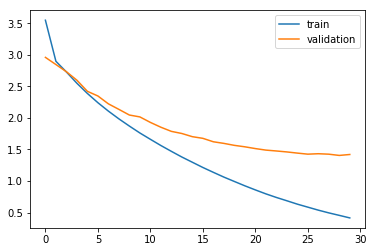

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


**Make Predictions**


Let's load the saved model to make predictions.

In [0]:
model = load_model('model.h1.30_aug_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})


In [0]:
pd.set_option('display.max_colwidth', 200)


In [33]:
pred_df.head(15)


,actual,predicted
0,he wanted to be rich,he wanted to rich
1,i love tom,i like tom
2,let us go home,lets go home
3,i love driving,i prefer to life
4,this is my dictionary,thats my dictionary
5,hi tom good morning,hi tom
6,why is she so popular,why is so popular
7,ill show you my room,ill show you my room
8,did tom oversleep,has tom
9,keep up the good work,look to good work


In [34]:
pred_df.tail(15)


,actual,predicted
9985,i didnt notice it,i didnt care
9986,she rode a camel,she gets for a tree
9987,trust me he said,what him me told
9988,tom grabbed his bag,tom has his nose
9989,what was tom like,how did tom like
9990,it looks like snow,it looks snow
9991,tom works slowly,tom is slowly
9992,i love rock,i like to
9993,our tv isnt working,our black is
9994,youre a racist,youre a workaholic


In [35]:
pred_df.sample(15)


,actual,predicted
7430,tom isnt done,tom isnt ready
4867,my cat loves catnip,my cat loves white
9371,happy easter,tom
7914,she trusts him,she trusted him
4464,you were so sweet,youre were curious
7080,im optimistic,im am
8177,we were robbed,we got robbed
217,tom is sneaky,tom is jealous
2350,lets go,lets go
6890,dont get fat,dont not fat
